## Import libraries needed

In [3]:
import pandas as pd
import numpy as np
import boto3
from pyathena import connect
import sagemaker
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
## set the session and roles for AWS
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Setup connection to Athena to pull in tables

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
# create the connection, this will be used anytime we need to query data from Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
## Verify we have the database created
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)
## store teh db_name in a variable
db_name = str(db_show.iloc[0]['database_name'])

In [8]:
## we need to query the tables in and do a Join so it is one table to run our EDA off
db_name

'ads_508_team_5'

* Given the columns that are listed in each of these datasets, not all of the columns in any of the orders dataset is needed, once to look at in more detail are order_items: price, freight_value. order_payments: payment_type, payment_installments, payment_value. Order_reviews: review_score, orders_dataset: order_status

### Query in the data that we think is necessary for customer churn

In [11]:
churn_eda_query = """ SELECT
                        c.*,
                        ord.order_status,
                        ord.order_purchase_timestamp,
                        ordi.price,
                        ordi.freight_value,
                        ordp.payment_type,
                        ordp.payment_installments,
                        ordp.payment_value,
                        ordr.review_score,
                        prd.product_photos_qty,
                        prd.product_weight_g,
                        prd.product_length_cm,
                        prd.product_height_cm,
                        prd.product_width_cm
                    FROM
                    {db}.customers_table c
                    INNER JOIN {db}.orders_table ord ON ord.customer_id = c.customer_id 
                    INNER JOIN {db}.order_items_table ordi ON ordi.order_id = ord.order_id
                    INNER JOIN {db}.product_table prd ON prd.product_id = ordi.product_id
                    INNER JOIN {db}.order_payments_table ordp ON ordp.order_id = ord.order_id
                    INNER JOIN {db}.order_reviews_table ordr ON ordr.order_id = ord.order_id""".format(db=db_name)

In [12]:
main_df =pd.read_sql(churn_eda_query, conn)
main_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,price,freight_value,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP,delivered,2017-05-16 15:05:35,124.99,21.88,credit_card,2,146.87,4,1.0,8683.0,54.0,64.0,31.0
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,289.00,46.48,credit_card,8,335.48,5,3.0,10150.0,89.0,15.0,40.0
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP,delivered,2018-05-19 16:07:45,139.94,17.79,credit_card,7,157.73,5,1.0,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,149.94,23.36,credit_card,1,173.30,5,1.0,12160.0,56.0,51.0,28.0
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP,delivered,2018-07-29 09:51:30,230.00,22.25,credit_card,8,252.25,5,1.0,5200.0,45.0,15.0,35.0


In [13]:
main_df.dtypes

customer_id                         object
customer_unique_id                  object
customer_zip_code_prefix            object
customer_city                       object
customer_state                      object
order_status                        object
order_purchase_timestamp    datetime64[ns]
price                              float64
freight_value                      float64
payment_type                        object
payment_installments                 int64
payment_value                      float64
review_score                         int64
product_photos_qty                 float64
product_weight_g                   float64
product_length_cm                  float64
product_height_cm                  float64
product_width_cm                   float64
dtype: object

In [14]:
## In order for us to get teh customer churn we need to figure out who has made reorders and who has not, we can use the customer_id key 
## and teh customer unique key

# conver teh timestamp to a date time
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
# get tehf irst and last purchase for each customer
purchase_dates = main_df.groupby('customer_unique_id').agg(first_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='min'),
                                                       last_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='max')).reset_index()
#Calculate the repurchase time in days for each customer
purchase_dates['repurchase_time'] = (purchase_dates['last_purchase'] - purchase_dates['first_purchase']).dt.days
churn_threshold = 180

# Identify churned customers based on the churn threshold
# Customers who have not made any repurchase within the churn threshold or who never made a repurchase
purchase_dates['churn'] = ((purchase_dates['repurchase_time'] > churn_threshold) | (purchase_dates['repurchase_time'] == 0)).astype(int)
df_with_churn = main_df.merge(purchase_dates[['customer_unique_id', 'churn']], on='customer_unique_id', how='inner')
df_with_churn['churn'].value_counts()

1    114069
0      4246
Name: churn, dtype: int64

### Churn Definition from above
* A value of 1 indicates that customer has churned because they haven't made a repruchase within 180 days of their first purchase
A churn value of 0 means that a customer has not churned, because they made a repurchase within 180 days after their first purchase

In [15]:
df_with_churn.describe()

,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,churn
count,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000,116606.000000,118295.000000,118295.000000,118295.000000,118295.000000,118315.000000
mean,120.651027,20.033024,2.943498,172.575651,4.014554,2.205144,2112.331011,30.265227,16.620009,23.075075,0.964113
std,184.109626,15.836523,2.778022,267.104661,1.400186,1.717429,3786.717861,16.189038,13.453941,11.749311,0.186010
min,0.850000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000000
25%,39.900000,13.080000,1.000000,60.850000,3.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000
50%,74.900000,16.280000,2.000000,108.200000,5.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000
75%,134.900000,21.180000,4.000000,189.260000,5.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000
max,6735.000000,409.680000,24.000000,13664.080000,5.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,1.000000


In [16]:
df_with_churn.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix    118315
customer_city                    0
customer_state                   0
order_status                     0
order_purchase_timestamp         0
price                            0
freight_value                    0
payment_type                     0
payment_installments             0
payment_value                    0
review_score                     0
product_photos_qty            1709
product_weight_g                20
product_length_cm               20
product_height_cm               20
product_width_cm                20
churn                            0
dtype: int64

In [17]:
df_with_churn['order_status'].value_counts()

delivered      115728
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: order_status, dtype: int64

In [18]:
df_with_churn['customer_state'].value_counts()

SP    49865
RJ    15425
MG    13718
RS     6539
PR     5988
SC     4319
BA     4069
DF     2500
GO     2453
ES     2351
PE     1903
CE     1556
MT     1128
PA     1124
MS      856
MA      849
PB      640
PI      574
RN      571
AL      462
SE      397
TO      339
RO      286
AM      172
AC       95
AP       84
RR       52
Name: customer_state, dtype: int64

In [19]:
df_with_churn['payment_type'].value_counts()

credit_card    87266
boleto         23018
voucher         6332
debit_card      1699
Name: payment_type, dtype: int64

In [21]:
def check_numeric_dtypes(dataset):
    category_columns = []
    for i in dataset:
        if dataset[i].dtype == 'int':
            category_columns.append(i)
        elif dataset[i].dtype == 'float':
            category_columns.append(i)
    return category_columns

In [36]:
num_cols = check_numeric_dtypes(df_with_churn)
num_cols

['price',
 'freight_value',
 'payment_installments',
 'payment_value',
 'review_score',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'churn']

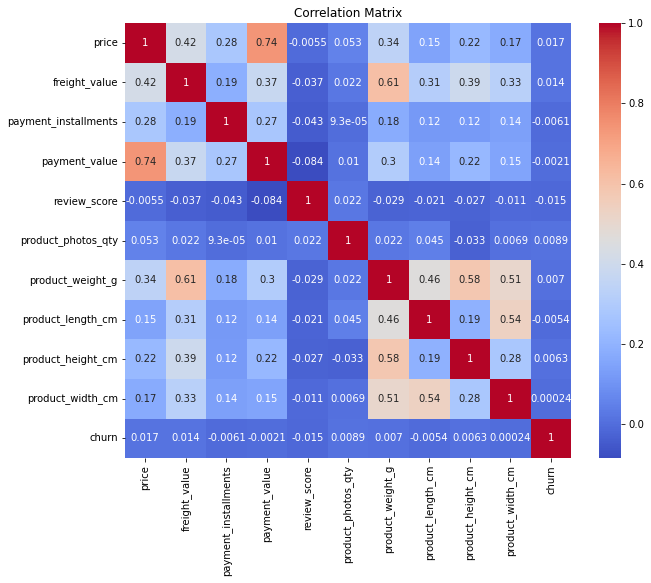

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_with_churn[num_cols].corr()
# corr_matrics = check_numeric_dtypes(df_with_churn).corr()
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

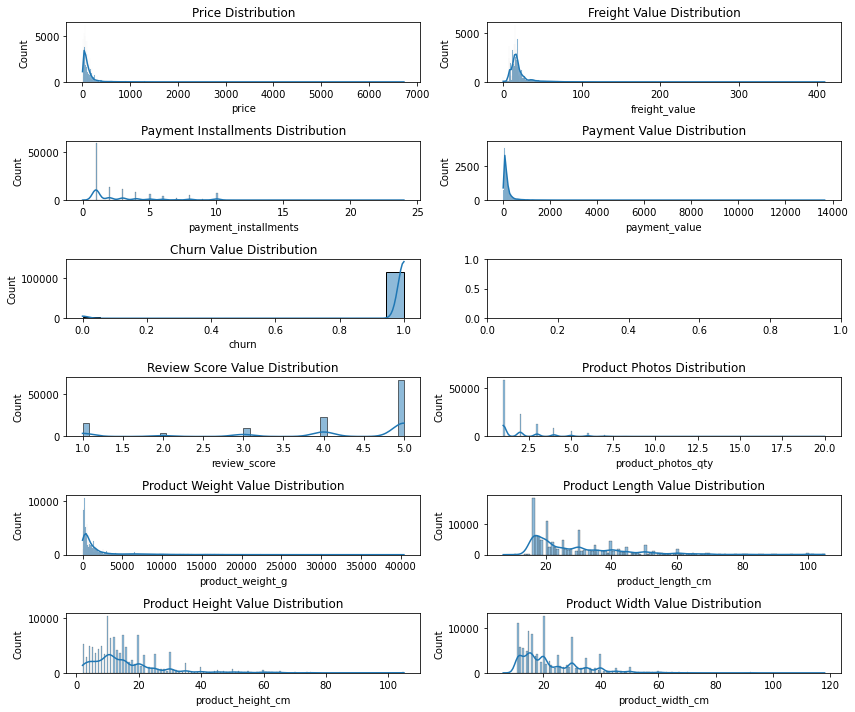

In [37]:
# Plotting distribution plots for numerical columns
fig, axs = plt.subplots(6, 2, figsize=(12, 10))

sns.histplot(df_with_churn["price"], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Price Distribution")

sns.histplot(df_with_churn["freight_value"], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Freight Value Distribution")

sns.histplot(df_with_churn["payment_installments"], kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Payment Installments Distribution")

sns.histplot(df_with_churn["payment_value"], kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Payment Value Distribution")

sns.histplot(df_with_churn["churn"], kde=True, ax=axs[2, 0])
axs[2, 0].set_title("Churn Value Distribution")

sns.histplot(df_with_churn["review_score"], kde=True, ax=axs[3, 0])
axs[3, 0].set_title("Review Score Value Distribution")

sns.histplot(df_with_churn["product_photos_qty"], kde=True, ax=axs[3, 1])
axs[3, 1].set_title("Product Photos Distribution")

sns.histplot(df_with_churn["product_weight_g"], kde=True, ax=axs[4, 0])
axs[4, 0].set_title("Product Weight Value Distribution")

sns.histplot(df_with_churn["product_length_cm"], kde=True, ax=axs[4, 1])
axs[4, 1].set_title("Product Length Value Distribution")

sns.histplot(df_with_churn["product_height_cm"], kde=True, ax=axs[5, 0])
axs[5, 0].set_title("Product Height Value Distribution")

sns.histplot(df_with_churn["product_width_cm"], kde=True, ax=axs[5, 1])
axs[5, 1].set_title("Product Width Value Distribution")

plt.tight_layout()
plt.show()

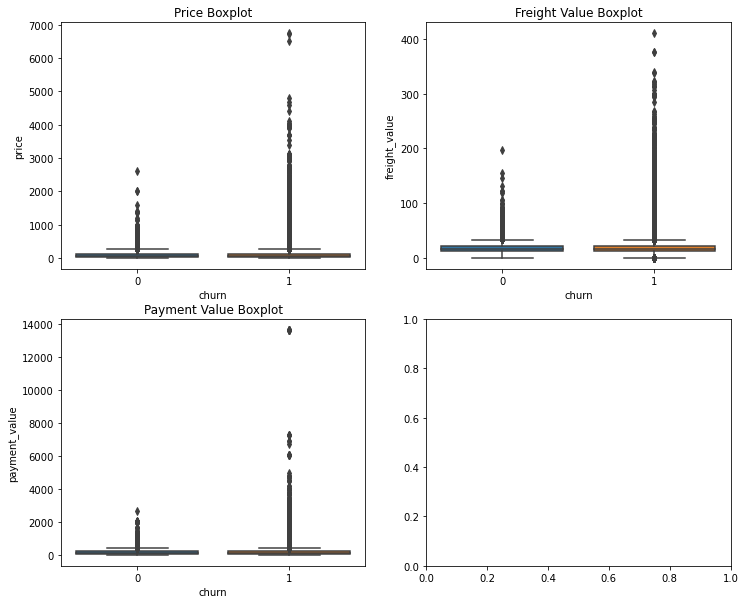

In [35]:
## create a boxplot for price freight_value payment_value by custmer churn
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x='churn', y='price', data=df_with_churn, ax=axs[0, 0])
axs[0, 0].set_title("Price Boxplot")
sns.boxplot(x='churn', y='freight_value', data=df_with_churn, ax=axs[0, 1])
axs[0, 1].set_title("Freight Value Boxplot")
sns.boxplot(x='churn', y='payment_value', data=df_with_churn, ax=axs[1, 0])
axs[1, 0].set_title("Payment Value Boxplot")
plt.show()


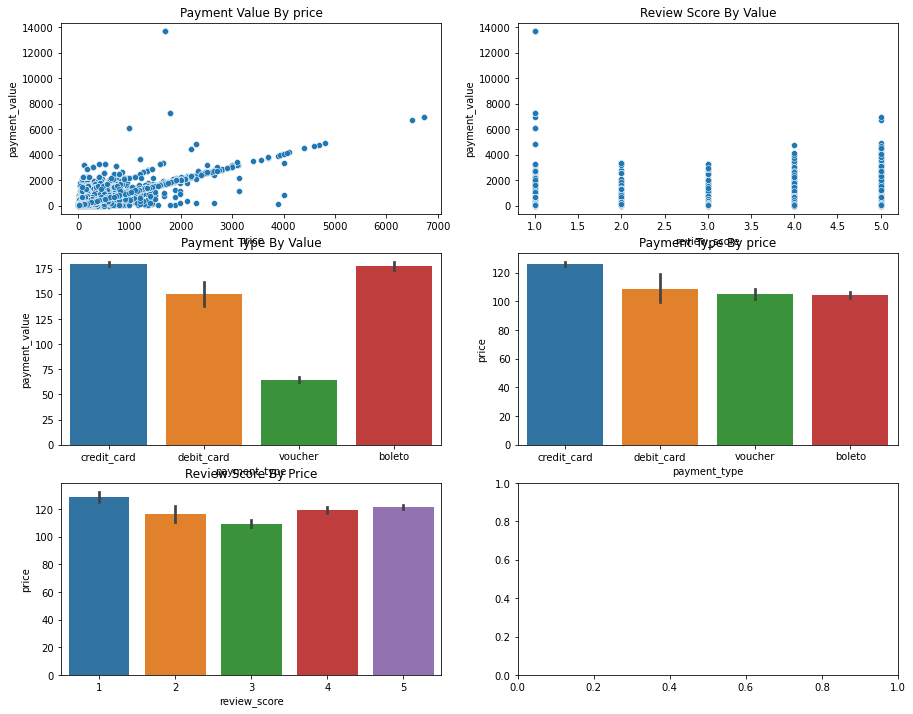

In [19]:
# create a scatter plot for the numeric features and churn
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
sns.scatterplot(y='payment_value', x='price', data=df_with_churn, ax=axs[0, 0])
axs[0, 0].set_title("Payment Value By price")
sns.scatterplot(x='review_score', y = 'payment_value', data=df_with_churn, ax=axs[0, 1])
axs[0, 1].set_title("Review Score By Value")

sns.barplot(x='payment_type', y = 'payment_value', data=df_with_churn, ax=axs[1, 0])
axs[1, 0].set_title("Payment Type By Value")
sns.barplot(x='payment_type', y = 'price', data=df_with_churn, ax=axs[1, 1])
axs[1, 1].set_title("Payment Type By price")
sns.barplot(x='review_score', y = 'price', data=df_with_churn, ax=axs[2, 0])
axs[2, 0].set_title("Review Score By Price")
plt.show();


In [38]:
df_with_churn['customer_city'].value_counts()

sao paulo             18728
rio de janeiro         8261
belo horizonte         3274
brasilia               2484
curitiba               1816
                      ...  
sao jose do piaui         1
jardim de piranhas        1
ciriaco                   1
aratiba                   1
eugenio de castro         1
Name: customer_city, Length: 4110, dtype: int64

## Pre-process the data

In [39]:
df_with_churn.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,price,freight_value,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,churn
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP,delivered,2017-05-16 15:05:35,124.99,21.88,credit_card,2,146.87,4,1.0,8683.0,54.0,64.0,31.0,1
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,289.00,46.48,credit_card,8,335.48,5,3.0,10150.0,89.0,15.0,40.0,1
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP,delivered,2018-05-19 16:07:45,139.94,17.79,credit_card,7,157.73,5,1.0,8267.0,52.0,52.0,17.0,1
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,149.94,23.36,credit_card,1,173.30,5,1.0,12160.0,56.0,51.0,28.0,1
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP,delivered,2018-07-29 09:51:30,230.00,22.25,credit_card,8,252.25,5,1.0,5200.0,45.0,15.0,35.0,1


In [40]:
# columns to drop: Ids, Zip, State. These are two unique columns to add to the model. Also drop Timestamp
# new dataframe
new_df = df_with_churn.drop(columns = ['customer_id', 
                                      'customer_unique_id', 
                                      'customer_zip_code_prefix', 
                                      'customer_city',
                                      'customer_state',
                                      'order_purchase_timestamp',
                                     ]
                           )
new_df.head()

,order_status,price,freight_value,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,churn
0,delivered,124.99,21.88,credit_card,2,146.87,4,1.0,8683.0,54.0,64.0,31.0,1
1,delivered,289.00,46.48,credit_card,8,335.48,5,3.0,10150.0,89.0,15.0,40.0,1
2,delivered,139.94,17.79,credit_card,7,157.73,5,1.0,8267.0,52.0,52.0,17.0,1
3,delivered,149.94,23.36,credit_card,1,173.30,5,1.0,12160.0,56.0,51.0,28.0,1
4,delivered,230.00,22.25,credit_card,8,252.25,5,1.0,5200.0,45.0,15.0,35.0,1


In [97]:
## Build new model without the photos quantity and other noisy colulmns
new_df_2 = df_with_churn.drop(columns = ['customer_id', 
                                      'customer_unique_id', 
                                      'customer_zip_code_prefix', 
                                      'customer_city',
                                      'customer_state',
                                      'order_purchase_timestamp',
                                         'payment_type',
                                         'order_status'
                                         
                                         
                                         
                                     ]
                           )

In [98]:
new_df.dtypes

order_status             object
price                   float64
freight_value           float64
payment_type             object
payment_installments      int64
payment_value           float64
review_score              int64
product_photos_qty      float64
product_weight_g        float64
product_length_cm       float64
product_height_cm       float64
product_width_cm        float64
churn                     int64
dtype: object

In [99]:
new_df_2.dtypes

price                   float64
freight_value           float64
payment_installments      int64
payment_value           float64
review_score              int64
product_photos_qty      float64
product_weight_g        float64
product_length_cm       float64
product_height_cm       float64
product_width_cm        float64
churn                     int64
dtype: object

In [100]:
new_df.isnull().sum()

order_status            0
price                   0
freight_value           0
payment_type            0
payment_installments    0
payment_value           0
review_score            0
product_photos_qty      0
product_weight_g        0
product_length_cm       0
product_height_cm       0
product_width_cm        0
churn                   0
dtype: int64

In [101]:
new_df_2.isnull().sum()

price                      0
freight_value              0
payment_installments       0
payment_value              0
review_score               0
product_photos_qty      1709
product_weight_g          20
product_length_cm         20
product_height_cm         20
product_width_cm          20
churn                      0
dtype: int64

In [102]:
def fillnullsmean(df):
    for column in df.columns:
        if df[column].isnull().any():
            column_mean = df[column].mean()
            df[column].fillna(column_mean, inplace = True)

In [103]:
fillnullsmean(new_df)

In [104]:
fillnullsmean(new_df_2)

In [105]:
new_df_2.isnull().sum()

price                   0
freight_value           0
payment_installments    0
payment_value           0
review_score            0
product_photos_qty      0
product_weight_g        0
product_length_cm       0
product_height_cm       0
product_width_cm        0
churn                   0
dtype: int64

In [106]:
new_df.isnull().sum()

order_status            0
price                   0
freight_value           0
payment_type            0
payment_installments    0
payment_value           0
review_score            0
product_photos_qty      0
product_weight_g        0
product_length_cm       0
product_height_cm       0
product_width_cm        0
churn                   0
dtype: int64

In [107]:
def check_category_dtypes(dataset):
    category_columns = []
    for i in dataset:
        if dataset[i].dtype == 'object':
            category_columns.append(i)
        elif dataset[i].dtype == 'category':
            category_columns.append(i)
    return category_columns

In [108]:
from numpy.lib.shape_base import column_stack
# apply OHE to the label_text column
def apply_ohe(dataset):
    # Assuming check_category_dtypes(dataset) correctly returns a list of categorical column names
    category_columns = check_category_dtypes(dataset)
    
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # Fit and transform the categorical columns
    ohe_data = ohe.fit_transform(dataset[category_columns])
    
    # Create a DataFrame with the encoded data and column names derived from the encoder
    new_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(category_columns), index=dataset.index)
    
    # Concatenate the original dataset (minus the categorical columns) with the new encoded DataFrame
    final_df = pd.concat([dataset.drop(columns=category_columns), new_df], axis=1)
    
    return final_df

In [109]:
## apply one hot encoding to the dataset
encoded_df = apply_ohe(new_df)
encoded_df

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,124.99,21.88,2,146.87,4,1.0,8683.0,54.0,64.0,31.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,289.00,46.48,8,335.48,5,3.0,10150.0,89.0,15.0,40.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,139.94,17.79,7,157.73,5,1.0,8267.0,52.0,52.0,17.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,149.94,23.36,1,173.30,5,1.0,12160.0,56.0,51.0,28.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,230.00,22.25,8,252.25,5,1.0,5200.0,45.0,15.0,35.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,74.90,13.88,6,88.78,4,2.0,611.0,22.0,22.0,23.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118311,114.90,14.16,3,129.06,5,1.0,1211.0,25.0,24.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118312,37.00,19.04,5,56.04,1,1.0,870.0,25.0,20.0,18.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118313,689.00,22.07,2,711.07,5,1.0,710.0,19.0,13.0,14.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [110]:
## split the data into taining and testing sets
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
X = encoded_df.drop(columns = 'churn')
y = encoded_df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)
## balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)
smoteen = SMOTEENN(random_state=42)
# Fit and resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smoteen, y_train_smoteen = smoteen.fit_resample(X_train, y_train)

In [111]:
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

# # Assuming Xt and y_train_smote are already defined
# plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_train_smote['churn'])

# # If y_train_smote is a Series or an array, just use it directly. If it's a DataFrame, access the relevant column.
# labels = y_train_smote.unique() if not isinstance(y_train_smote, pd.DataFrame) else y_train_smote['churn'].unique()

# # Create custom handles
# handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10),
#            Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10)]

# # Add legend to plot
# plt.legend(handles, labels)
# plt.show()

In [112]:
## Scale the data
scaler = StandardScaler()
scaler.fit(X_train_smote)
X_train_scaled = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


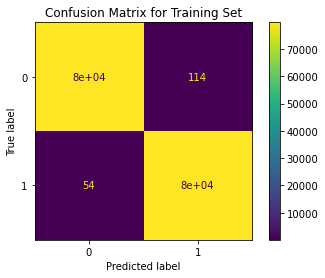

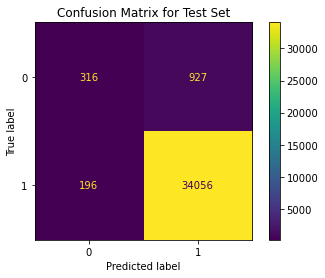

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79817
           1       1.00      1.00      1.00     79817

    accuracy                           1.00    159634
   macro avg       1.00      1.00      1.00    159634
weighted avg       1.00      1.00      1.00    159634


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.62      0.25      0.36      1243
           1       0.97      0.99      0.98     34252

    accuracy                           0.97     35495
   macro avg       0.80      0.62      0.67     35495
weighted avg       0.96      0.97      0.96     35495



In [113]:
## build a RF model to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_smote)
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)
cm_train = confusion_matrix(y_train_smote, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix plots
labels = rf.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

# Plot confusion matrix for training set
cmplot_train.plot()
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for test set
cmplot_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# Build classification reports
rf_train_report = classification_report(y_train_smote, y_pred_train)
rf_test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set:")
print(rf_train_report)
print("\nClassification Report for Test Set:")
print(rf_test_report)


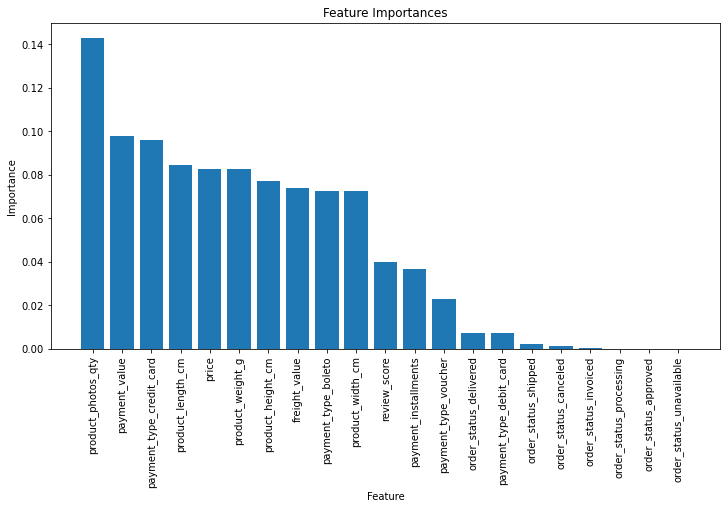

In [114]:
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [115]:
scaler = StandardScaler()
scaler.fit(X_train_smoteen)
X_train_scaled = scaler.transform(X_train_smoteen)
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


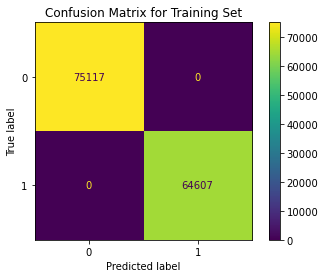

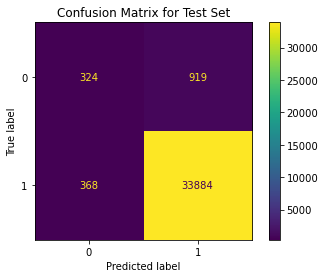

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75117
           1       1.00      1.00      1.00     64607

    accuracy                           1.00    139724
   macro avg       1.00      1.00      1.00    139724
weighted avg       1.00      1.00      1.00    139724


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.47      0.26      0.33      1243
           1       0.97      0.99      0.98     34252

    accuracy                           0.96     35495
   macro avg       0.72      0.62      0.66     35495
weighted avg       0.96      0.96      0.96     35495



In [116]:
## build a RF model to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_smoteen)
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)
cm_train = confusion_matrix(y_train_smoteen, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix plots
labels = rf.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

# Plot confusion matrix for training set
cmplot_train.plot()
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for test set
cmplot_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# Build classification reports
rf_train_report = classification_report(y_train_smoteen, y_pred_train)
rf_test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set:")
print(rf_train_report)
print("\nClassification Report for Test Set:")
print(rf_test_report)


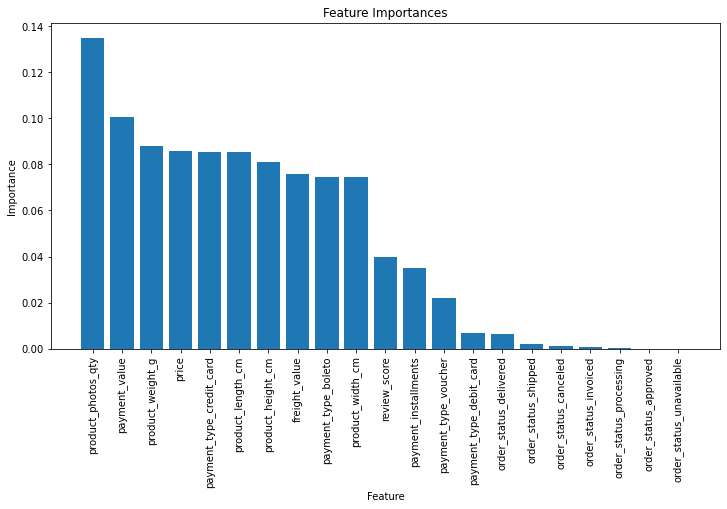

In [117]:
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

### Use New_Df2 for another model

In [118]:
X_new = new_df_2.drop(columns = 'churn')
y_new = new_df_2['churn']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = .30, random_state = 42)
## balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)
smoteen = SMOTEENN(random_state=42)
# Fit and resample the training data
X_train_smote_new, y_train_smote_new = smote.fit_resample(X_train_new, y_train_new)
X_train_smoteen_new, y_train_smoteen_new = smoteen.fit_resample(X_train_new, y_train_new)

In [119]:
X_new

,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,124.99,21.88,2,146.87,4,1.0,8683.0,54.0,64.0,31.0
1,289.00,46.48,8,335.48,5,3.0,10150.0,89.0,15.0,40.0
2,139.94,17.79,7,157.73,5,1.0,8267.0,52.0,52.0,17.0
3,149.94,23.36,1,173.30,5,1.0,12160.0,56.0,51.0,28.0
4,230.00,22.25,8,252.25,5,1.0,5200.0,45.0,15.0,35.0
...,...,...,...,...,...,...,...,...,...,...
118310,74.90,13.88,6,88.78,4,2.0,611.0,22.0,22.0,23.0
118311,114.90,14.16,3,129.06,5,1.0,1211.0,25.0,24.0,22.0
118312,37.00,19.04,5,56.04,1,1.0,870.0,25.0,20.0,18.0
118313,689.00,22.07,2,711.07,5,1.0,710.0,19.0,13.0,14.0


In [128]:
scaler_new = StandardScaler()
scaler_new.fit(X_train_smote_new)
X_train_scaled_new = scaler_new.transform(X_train_smote_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

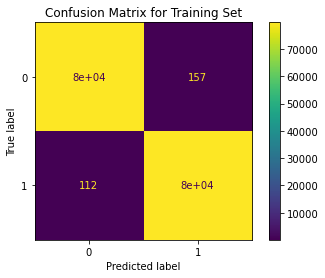

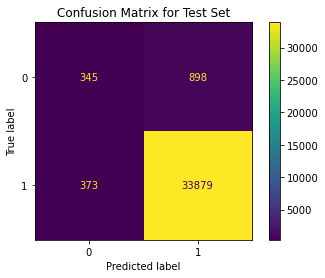

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79817
           1       1.00      1.00      1.00     79817

    accuracy                           1.00    159634
   macro avg       1.00      1.00      1.00    159634
weighted avg       1.00      1.00      1.00    159634


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.48      0.28      0.35      1243
           1       0.97      0.99      0.98     34252

    accuracy                           0.96     35495
   macro avg       0.73      0.63      0.67     35495
weighted avg       0.96      0.96      0.96     35495



In [129]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled_new, y_train_smote_new)
y_pred_train = rf.predict(X_train_scaled_new)
y_pred_test = rf.predict(X_test_scaled_new)
cm_train = confusion_matrix(y_train_smote_new, y_pred_train)
cm_test = confusion_matrix(y_test_new, y_pred_test)

# Create confusion matrix plots
labels = rf.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

# Plot confusion matrix for training set
cmplot_train.plot()
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for test set
cmplot_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# Build classification reports
rf_train_report = classification_report(y_train_smote_new, y_pred_train)
rf_test_report = classification_report(y_test_new, y_pred_test)

print("Classification Report for Training Set:")
print(rf_train_report)
print("\nClassification Report for Test Set:")
print(rf_test_report)

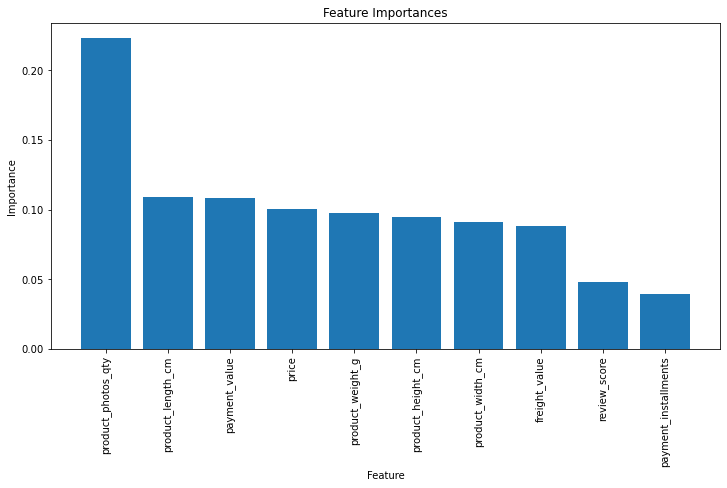

In [130]:
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'feature': X_new.columns, 'importance': importances})

# Sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [131]:
# Initialize the Logistic Regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train_scaled_new, y_train_smote_new)

# Make predictions on the test set
y_pred_log_train = log_reg.predict(X_train_scaled_new)
y_pred_log_test = log_reg.predict(X_test_scaled_new)
# Evaluate the model
accuracy = accuracy_score(y_test_new, y_pred_log_test)
conf_matrix = confusion_matrix(y_test_new, y_pred_log_test)
report = classification_report(y_test_new, y_pred_log_test)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{report}')

Accuracy: 0.5243555430342302
Confusion Matrix:
[[  664   579]
 [16304 17948]]
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.53      0.07      1243
           1       0.97      0.52      0.68     34252

    accuracy                           0.52     35495
   macro avg       0.50      0.53      0.38     35495
weighted avg       0.94      0.52      0.66     35495



In [133]:
scaler_smoteen = StandardScaler()
scaler_new.fit(X_train_smoteen_new)
X_train_scaled_new_2 = scaler_new.transform(X_train_smoteen_new)
X_test_scaled_new_2 = scaler_new.transform(X_test_new)

In [134]:
log_reg_new = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train_scaled_new_2, y_train_smoteen_new)

# Make predictions on the test set
y_pred_log_train_2 = log_reg.predict(X_train_scaled_new_2)
y_pred_log_test_2 = log_reg.predict(X_test_scaled_new_2)
# Evaluate the model
accuracy = accuracy_score(y_test_new, y_pred_log_test_2)
conf_matrix = confusion_matrix(y_test_new, y_pred_log_test_2)
report = classification_report(y_test_new, y_pred_log_test_2)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{report}')

Accuracy: 0.2658966051556557
Confusion Matrix:
[[  959   284]
 [25773  8479]]
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.77      0.07      1243
           1       0.97      0.25      0.39     34252

    accuracy                           0.27     35495
   macro avg       0.50      0.51      0.23     35495
weighted avg       0.93      0.27      0.38     35495



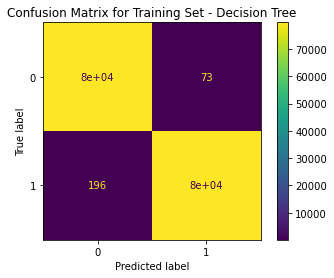

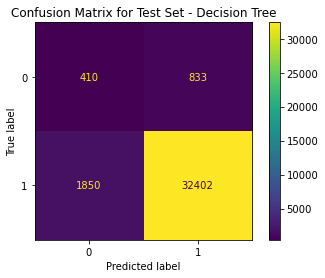

Classification Report for Training Set - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79817
           1       1.00      1.00      1.00     79817

    accuracy                           1.00    159634
   macro avg       1.00      1.00      1.00    159634
weighted avg       1.00      1.00      1.00    159634


Classification Report for Test Set - Decision Tree:
              precision    recall  f1-score   support

           0       0.18      0.33      0.23      1243
           1       0.97      0.95      0.96     34252

    accuracy                           0.92     35495
   macro avg       0.58      0.64      0.60     35495
weighted avg       0.95      0.92      0.93     35495



In [135]:
## build out a decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled_new, y_train_smote_new)

# Make predictions on the training and testing sets
y_pred_train_dt = dt.predict(X_train_scaled_new)
y_pred_test_dt = dt.predict(X_test_scaled_new)

# Generate confusion matrices for the training and testing sets
cm_train_dt = confusion_matrix(y_train_smote_new, y_pred_train_dt)
cm_test_dt = confusion_matrix(y_test_new, y_pred_test_dt)

# Create confusion matrix plots
labels_dt = dt.classes_
cmplot_train_dt = ConfusionMatrixDisplay(confusion_matrix=cm_train_dt, display_labels=labels_dt)
cmplot_test_dt = ConfusionMatrixDisplay(confusion_matrix=cm_test_dt, display_labels=labels_dt)

# Plot confusion matrix for training set
cmplot_train_dt.plot()
plt.title('Confusion Matrix for Training Set - Decision Tree')
plt.show()

# Plot confusion matrix for test set
cmplot_test_dt.plot()
plt.title('Confusion Matrix for Test Set - Decision Tree')
plt.show()

# Build classification reports for the Decision Tree model
dt_train_report = classification_report(y_train_smote_new, y_pred_train_dt)
dt_test_report = classification_report(y_test_new, y_pred_test_dt)

print("Classification Report for Training Set - Decision Tree:")
print(dt_train_report)
print("\nClassification Report for Test Set - Decision Tree:")
print(dt_test_report)

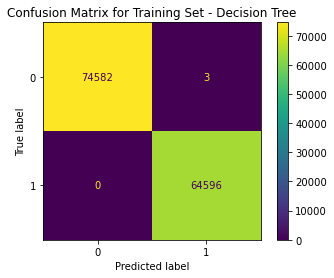

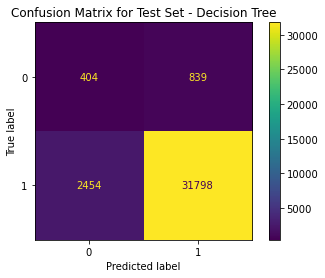

Classification Report for Training Set - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74585
           1       1.00      1.00      1.00     64596

    accuracy                           1.00    139181
   macro avg       1.00      1.00      1.00    139181
weighted avg       1.00      1.00      1.00    139181


Classification Report for Test Set - Decision Tree:
              precision    recall  f1-score   support

           0       0.14      0.33      0.20      1243
           1       0.97      0.93      0.95     34252

    accuracy                           0.91     35495
   macro avg       0.56      0.63      0.57     35495
weighted avg       0.95      0.91      0.92     35495



In [137]:
### USe SMOTEEN
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled_new_2, y_train_smoteen_new)

# Make predictions on the training and testing sets
y_pred_train_dt = dt.predict(X_train_scaled_new_2)
y_pred_test_dt = dt.predict(X_test_scaled_new_2)

# Generate confusion matrices for the training and testing sets
cm_train_dt = confusion_matrix(y_train_smoteen_new, y_pred_train_dt)
cm_test_dt = confusion_matrix(y_test_new, y_pred_test_dt)

# Create confusion matrix plots
labels_dt = dt.classes_
cmplot_train_dt = ConfusionMatrixDisplay(confusion_matrix=cm_train_dt, display_labels=labels_dt)
cmplot_test_dt = ConfusionMatrixDisplay(confusion_matrix=cm_test_dt, display_labels=labels_dt)

# Plot confusion matrix for training set
cmplot_train_dt.plot()
plt.title('Confusion Matrix for Training Set - Decision Tree')
plt.show()

# Plot confusion matrix for test set
cmplot_test_dt.plot()
plt.title('Confusion Matrix for Test Set - Decision Tree')
plt.show()

# Build classification reports for the Decision Tree model
dt_train_report = classification_report(y_train_smoteen_new, y_pred_train_dt)
dt_test_report = classification_report(y_test_new, y_pred_test_dt)

print("Classification Report for Training Set - Decision Tree:")
print(dt_train_report)
print("\nClassification Report for Test Set - Decision Tree:")
print(dt_test_report)

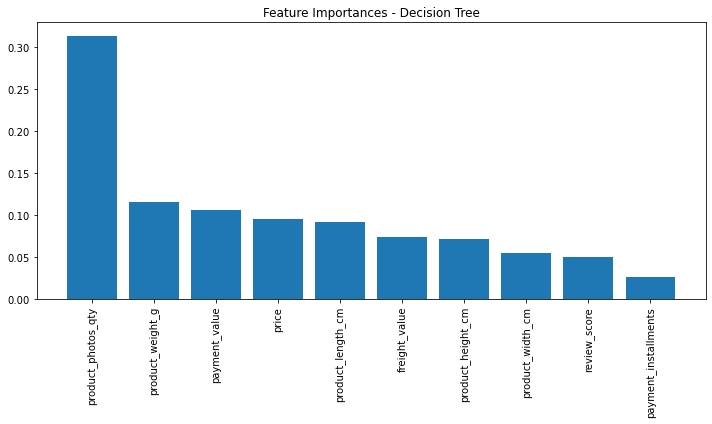

In [140]:
feature_names = X_train_new.columns
feature_importances = dt.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Decision Tree')
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), np.array(feature_names)[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [159]:
#### CREATE a Light Gradient bossting model with very limited features
new_df_3 = df_with_churn.drop(columns = ['customer_id', 
                                      'customer_unique_id', 
                                      'customer_zip_code_prefix', 
                                      'customer_city',
                                      'customer_state',
                                      'order_purchase_timestamp',
                                         'payment_type',
                                         'order_status',
                                         'product_height_cm',
                                         'product_width_cm',
                                         'review_score',
                                         'payment_installments'
                                         
                                         
                                         
                                         
                                     ]
                           )

In [165]:
new_df_4 = df_with_churn.drop(columns = ['customer_id', 
                                      'customer_unique_id', 
                                      'customer_zip_code_prefix', 
                                      'customer_city',
                                      'customer_state',
                                      'order_purchase_timestamp'
                                         
                                         
                                         
                                     ]
                           )

In [166]:
encoded_df_4 = apply_ohe(new_df_4)
encoded_df_4

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,124.99,21.88,2,146.87,4,1.0,8683.0,54.0,64.0,31.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,289.00,46.48,8,335.48,5,3.0,10150.0,89.0,15.0,40.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,139.94,17.79,7,157.73,5,1.0,8267.0,52.0,52.0,17.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,149.94,23.36,1,173.30,5,1.0,12160.0,56.0,51.0,28.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,230.00,22.25,8,252.25,5,1.0,5200.0,45.0,15.0,35.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,74.90,13.88,6,88.78,4,2.0,611.0,22.0,22.0,23.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118311,114.90,14.16,3,129.06,5,1.0,1211.0,25.0,24.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118312,37.00,19.04,5,56.04,1,1.0,870.0,25.0,20.0,18.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118313,689.00,22.07,2,711.07,5,1.0,710.0,19.0,13.0,14.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
fillnullsmean(new_df_3)

In [167]:
fillnullsmean(encoded_df_4)

In [162]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
X_lgm = new_df_3.drop(columns = 'churn')
y_lgm = new_df_3['churn']
X_train_lgm, X_test_lgm, y_train_lgm, y_test_lgm = train_test_split(X_lgm, y_lgm, test_size = .30, random_state = 42)
## balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)
smoteen = SMOTEENN(random_state=42)
# Fit and resample the training data
X_train_smote_lgm, y_train_smote_lgm = smote.fit_resample(X_train_lgm, y_train_lgm)
X_train_smoteen_lgm, y_train_smoteen_lgm = smoteen.fit_resample(X_train_lgm, y_train_lgm)
## scaling both samples
scaler_new_lgm_smote = StandardScaler()
scaler_new_lgm_smote.fit(X_train_smote_lgm)
X_train_scaled_new_smote = scaler_new_lgm_smote.transform(X_train_smote_lgm)
X_test_scaled_new_smote = scaler_new_lgm_smote.transform(X_test_lgm)

## SMOTTEN
scaler_new_lgm_smoteen = StandardScaler()
scaler_new_lgm_smoteen.fit(X_train_smoteen_lgm)
X_train_scaled_new_smoteen = scaler_new_lgm_smoteen.transform(X_train_smoteen_lgm)
X_test_scaled_new_smoteen = scaler_new_lgm_smoteen.transform(X_test_lgm)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

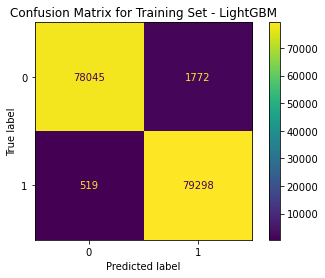

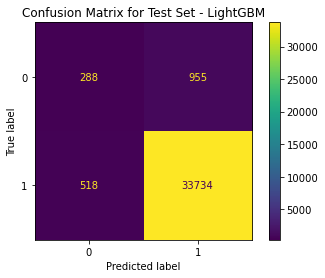

Classification Report for Training Set - LightGBM:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     79817
           1       0.98      0.99      0.99     79817

    accuracy                           0.99    159634
   macro avg       0.99      0.99      0.99    159634
weighted avg       0.99      0.99      0.99    159634


Classification Report for Test Set - LightGBM:
              precision    recall  f1-score   support

           0       0.36      0.23      0.28      1243
           1       0.97      0.98      0.98     34252

    accuracy                           0.96     35495
   macro avg       0.66      0.61      0.63     35495
weighted avg       0.95      0.96      0.95     35495



In [163]:
# Define the parameter space for Bayesian optimization
search_spaces = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0),
}

# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Perform the hyperparameter search
bayes_search.fit(X_train_scaled_new_smote, y_train_smote_lgm)

# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)

# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled_new_smote)
y_pred_test = bayes_search.predict(X_test_scaled_new_smote)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train_smote_lgm, y_pred_train)
cm_test = confusion_matrix(y_test_new, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LightGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LightGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train_smote_lgm, y_pred_train)
test_report = classification_report(y_test_new, y_pred_test)

print("Classification Report for Training Set - LightGBM:")
print(train_report)
print("\nClassification Report for Test Set - LightGBM:")
print(test_report)


In [149]:
new_df_3

,price,freight_value,payment_value,product_weight_g,product_length_cm,churn
0,124.99,21.88,146.87,8683.0,54.0,1
1,289.00,46.48,335.48,10150.0,89.0,1
2,139.94,17.79,157.73,8267.0,52.0,1
3,149.94,23.36,173.30,12160.0,56.0,1
4,230.00,22.25,252.25,5200.0,45.0,1
...,...,...,...,...,...,...
118310,74.90,13.88,88.78,611.0,22.0,1
118311,114.90,14.16,129.06,1211.0,25.0,1
118312,37.00,19.04,56.04,870.0,25.0,1
118313,689.00,22.07,711.07,710.0,19.0,1


* This data above is what we will conider using for the customer churn metric. This model was able to generalize well on this and there seems to be no bias within this data. Given that the model did not perform the best on the minority class it still did failry well with a precision of .48 and a recall of .25.

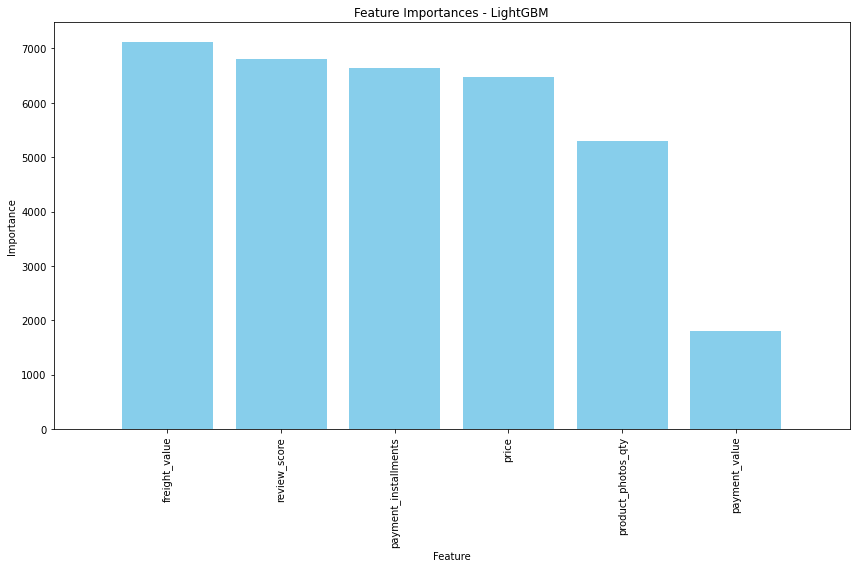

In [164]:
# Get feature importances from the best LightGBM model
best_lgbm = bayes_search.best_estimator_
importances = best_lgbm.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - LightGBM")
plt.bar(range(X_train_smoteen_lgm.shape[1]), importances[indices],
        align="center", color='skyblue')
plt.xticks(range(X_train_smoteen_lgm.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train_smoteen_lgm.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 51686, number of negative: 60093
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3599
[LightGBM] [Info] Number of data points in the train set: 111779, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462395 -> initscore=-0.150706
[LightGBM] [Info] Start training from score -0.150706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

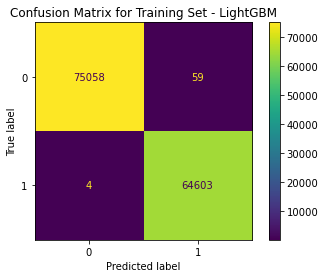

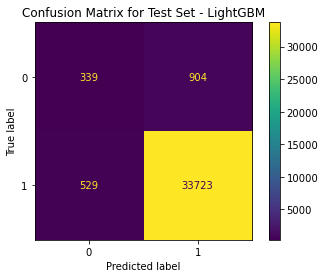

Classification Report for Training Set - LightGBM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75117
           1       1.00      1.00      1.00     64607

    accuracy                           1.00    139724
   macro avg       1.00      1.00      1.00    139724
weighted avg       1.00      1.00      1.00    139724


Classification Report for Test Set - LightGBM:
              precision    recall  f1-score   support

           0       0.39      0.27      0.32      1243
           1       0.97      0.98      0.98     34252

    accuracy                           0.96     35495
   macro avg       0.68      0.63      0.65     35495
weighted avg       0.95      0.96      0.96     35495



In [168]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")
X_lgm = encoded_df_4.drop(columns = 'churn')
y_lgm = encoded_df_4['churn']
X_train_lgm, X_test_lgm, y_train_lgm, y_test_lgm = train_test_split(X_lgm, y_lgm, test_size = .30, random_state = 42)
## balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)
smoteen = SMOTEENN(random_state=42)
# Fit and resample the training data
X_train_smote_lgm, y_train_smote_lgm = smote.fit_resample(X_train_lgm, y_train_lgm)
X_train_smoteen_lgm, y_train_smoteen_lgm = smoteen.fit_resample(X_train_lgm, y_train_lgm)
## scaling both samples
scaler_new_lgm_smote = StandardScaler()
scaler_new_lgm_smote.fit(X_train_smote_lgm)
X_train_scaled_new_smote = scaler_new_lgm_smote.transform(X_train_smote_lgm)
X_test_scaled_new_smote = scaler_new_lgm_smote.transform(X_test_lgm)

## SMOTTEN
scaler_new_lgm_smoteen = StandardScaler()
scaler_new_lgm_smoteen.fit(X_train_smoteen_lgm)
X_train_scaled_new_smoteen = scaler_new_lgm_smoteen.transform(X_train_smoteen_lgm)
X_test_scaled_new_smoteen = scaler_new_lgm_smoteen.transform(X_test_lgm)
# Define the parameter space for Bayesian optimization
search_spaces = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 1000),
    'num_leaves': Integer(20, 40),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(100, 500),
    'subsample': Real(0.5, 1.0),
}

# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Set up the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=10,  # Reduced for quicker execution, adjust as needed
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Perform the hyperparameter search
bayes_search.fit(X_train_scaled_new_smoteen, y_train_smoteen_lgm)

# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)

# Make predictions on both training and testing sets using the best model
y_pred_train = bayes_search.predict(X_train_scaled_new_smoteen)
y_pred_test = bayes_search.predict(X_test_scaled_new_smoteen)

# Generate and display confusion matrices
cm_train = confusion_matrix(y_train_smoteen_lgm, y_pred_train)
cm_test = confusion_matrix(y_test_new, y_pred_test)

labels = bayes_search.best_estimator_.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

cmplot_train.plot()
plt.title('Confusion Matrix for Training Set - LightGBM')
plt.show()

cmplot_test.plot()
plt.title('Confusion Matrix for Test Set - LightGBM')
plt.show()

# Generate classification reports
train_report = classification_report(y_train_smoteen_lgm, y_pred_train)
test_report = classification_report(y_test_new, y_pred_test)

print("Classification Report for Training Set - LightGBM:")
print(train_report)
print("\nClassification Report for Test Set - LightGBM:")
print(test_report)

IndexError: index 18 is out of bounds for axis 0 with size 10

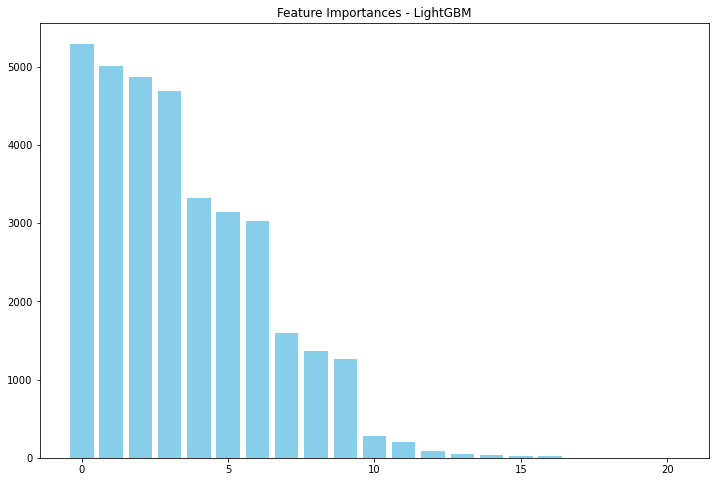

In [169]:
best_lgbm = bayes_search.best_estimator_
importances = best_lgbm.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - LightGBM")
plt.bar(range(X_train_smoteen_lgm.shape[1]), importances[indices],
        align="center", color='skyblue')
plt.xticks(range(X_train_smoteen_lgm.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train_smoteen_lgm.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}